# Assignment

**Target**:

- Achive 99.4% Test accuracy consistently from earlier Test Accuracy of 99.40 once 

**Results**:
- Parameters: 7,712
- Best Training Accuracy: 99.37%
- Best Test Accuracy: 99.4000%

**Analysis**:
- Added image augementation of rotation +4 to -4 degree
- Reduced dropout from 0.1 to 0.08. This is being done to ensure my model gets more weights to predict.
- Have been able to reach 99.4% test accuracy consistently within 8K parameters


# Solution

In [34]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 7
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 5
        self.dropout = nn.Dropout(0.07)
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        # x = self.dropout(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        # x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        # x = self.dropout(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [36]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        # nn.init.zeros_(m.bias)

In [37]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
# model.apply(weight_init)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
            Conv2d-8           [-1, 20, 22, 22]           1,800
       BatchNorm2d-9           [-1, 20, 22, 22]              40
             ReLU-10           [-1, 20, 22, 22]               0
          Dropout-11           [-1, 20, 22, 22]               0
        MaxPool2d-12           [-1, 20, 11, 11]               0
           Conv2d-13           [-1, 10, 11, 11]             200
      BatchNorm2d-14           [-1, 10,

In [38]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomHorizontalFlip(p=0.2),
                        # transforms.ColorJitter(brightness=0.01, contrast=0.01),
                        transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [39]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_losses.append(loss)
        optimizer.step()
        scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [40]:
model = Net().to(device)

In [41]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=0.01,
#                                               max_lr=0.1)

from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = StepLR(optimizer, step_size=4500, gamma=0.1)
# scheduler = MultiStepLR(optimizer, milestones=[10,12,14], gamma=0.1)

In [42]:

for epoch in range(1, 15):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.0752125009894371 batch_id=468 Accuracy=92.02: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]



Test set: Average loss: 0.0592, Accuracy: 9812/10000 (98.1200%)



loss=0.01667499728500843 batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]



Test set: Average loss: 0.0472, Accuracy: 9845/10000 (98.4500%)



loss=0.042152900248765945 batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:29<00:00, 16.04it/s]



Test set: Average loss: 0.0353, Accuracy: 9887/10000 (98.8700%)



loss=0.03698549419641495 batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]



Test set: Average loss: 0.0344, Accuracy: 9885/10000 (98.8500%)



loss=0.025376802310347557 batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:29<00:00, 15.87it/s]



Test set: Average loss: 0.0309, Accuracy: 9905/10000 (99.0500%)



loss=0.07272309809923172 batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:29<00:00, 16.02it/s]



Test set: Average loss: 0.0281, Accuracy: 9903/10000 (99.0300%)



loss=0.015030262060463428 batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:29<00:00, 15.94it/s]



Test set: Average loss: 0.0289, Accuracy: 9910/10000 (99.1000%)



loss=0.005469195079058409 batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:29<00:00, 16.11it/s]



Test set: Average loss: 0.0278, Accuracy: 9912/10000 (99.1200%)



loss=0.012685845606029034 batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]



Test set: Average loss: 0.0265, Accuracy: 9921/10000 (99.2100%)



loss=0.0014446512795984745 batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s]



Test set: Average loss: 0.0216, Accuracy: 9937/10000 (99.3700%)



loss=0.022858763113617897 batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]



Test set: Average loss: 0.0201, Accuracy: 9942/10000 (99.4200%)



loss=0.002393869450315833 batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:29<00:00, 15.94it/s]



Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.3700%)



loss=0.022298207506537437 batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:29<00:00, 15.92it/s]



Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.4100%)



loss=0.021335842087864876 batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:29<00:00, 15.90it/s]



Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.4000%)



In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

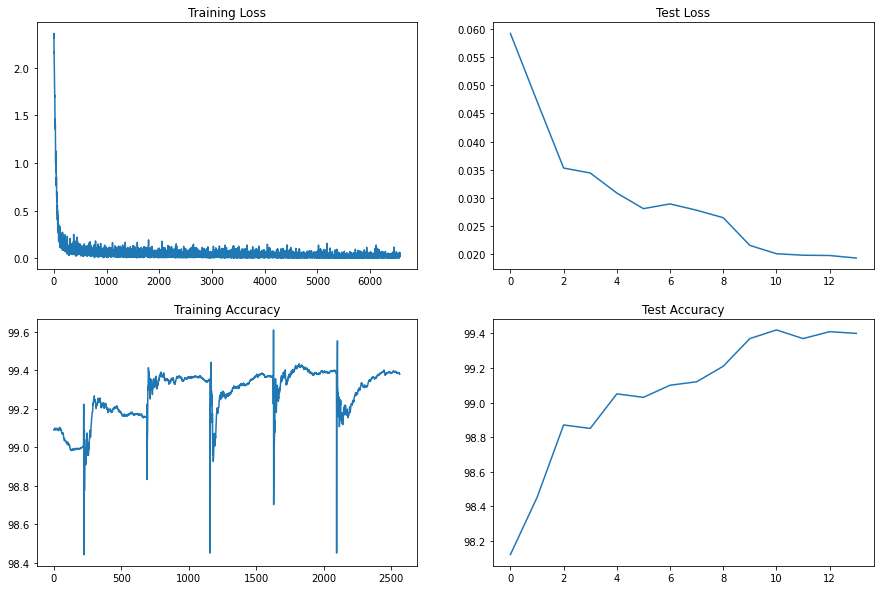

In [44]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")